In [1]:
from collections import defaultdict
import json
import networkx as nx
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from scripts.eas_lists import OsoData
from scripts.oso_db import execute_query
from scripts.processing import (
    github_event_processor, 
    github_active_developers, 
    github_repos_analysis,
    github_network_graph
)

from visualizations.contribution_heatmap import contribution_heatmap
from visualizations.network_graph import network_graph
from visualizations.stacked_area import activity_plot
from visualizations.venn_diagram import venn3_diagram


DPI = 144 
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = DPI
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['font.sans-serif'] = ['Helvetica', 'Arial', 'sans-serif']

OP_RED = "#FF0420"
OP_MED_RED = "#FF6969"
OP_LIGHT_RED = "#FFCCDD"

# Fetch / update data

In [26]:
DATA_DIR  = "data/RPGF3/"
DATA_PATH = DATA_DIR + "RPGF3_cleaned_applicant_data_final.json"

RPGF2_DATE = '2023-04-01'
START_DATE = '2019-01-01'
END_DATE = '2023-10-01'

In [27]:
oso = OsoData(DATA_PATH)
individuals = list(oso.df[oso.df['Applicant Type'] == 'INDIVIDUAL']['Slug: Primary'].values)
slugs_to_names = dict(zip(oso.df['Slug: Primary'], oso.df['Project Name']))
slugs_to_names = {k: v[:30] for k,v in slugs_to_names.items()}
slugs = [s for s in oso.get_project_slugs() if s not in individuals]

Loaded 315 OSS projects from data/RPGF3/RPGF3_cleaned_applicant_data_final.json.
Identified 315 unique slugs.


In [28]:
# create a mapping of projects to collections
query = """
    SELECT p."slug", c."slug" 
    FROM project p 
    JOIN collection_projects_project cpp ON p."id" = cpp."projectId"
    JOIN collection c ON cpp."collectionId" = c."id"
    """
result = execute_query(query, col_names=False)
cpp = {k: sorted([v for v, key in result if key == k]) for k in set(key for _, key in result)}

# Visualize dataset coverage

Total projects: 450


(<Figure size 1440x1440 with 1 Axes>, <Axes: >)

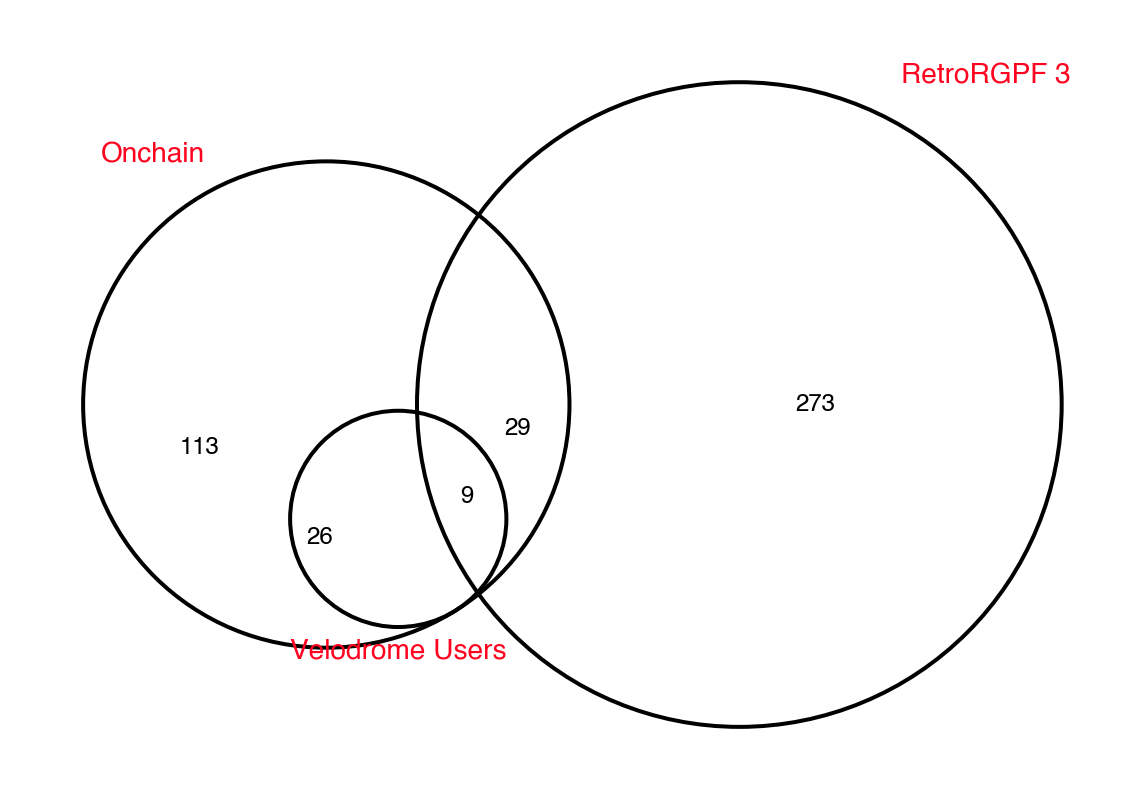

In [29]:
collection_slugs = ["velodrome-users", "op-onchain", "op-rpgf3"]
all_slugs = set([p for c,ps in cpp.items() if c in collection_slugs for p in ps])
total_projects = len(all_slugs)
print("Total projects:", total_projects)

venn3_diagram(
    [set(ps) for c,ps in cpp.items() if c in collection_slugs], 
    ["Onchain", "RetroRGPF 3", "Velodrome Users"],
    labelcolor=OP_RED,
    fontsize=12
)

# Developer Activity

In [30]:
slugs = cpp['velodrome-users']

In [31]:
def annualize_ticks(dataframe, ax):
    months = dataframe['month'].nunique()
    ax.set_xlim([0,months-1])
    ax.set_xticks([x for x in range(0,months,12)])
    xticklabels = [x[:-3] for x in sorted(df_devs['month'].unique())[::12]]
    ax.set_xticklabels(xticklabels)

In [32]:
slugs_param = "','".join(slugs)

devs_query = execute_query(f"""
    WITH Devs AS (
        SELECT 
            p."slug" AS "slug",
            e."fromId" AS "fromId",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM') AS "month",
            CASE WHEN COUNT(DISTINCT e."time") >= 10 THEN 1 ELSE 0 END AS "active_developer"
                FROM event e             
        JOIN project_artifacts_artifact paa ON e."toId" = paa."artifactId"            
        JOIN project p ON paa."projectId" = p.id         
        WHERE
            e."typeId" = 4 -- COMMIT CODE EVENTS ONLY
            AND p.slug IN ('{slugs_param}')
        GROUP BY
            p."slug",
            e."fromId",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM')
    )
    SELECT 
        slug,
        month,
        SUM("active_developer")
    FROM Devs
    WHERE month >= '{START_DATE[:-3]}' AND month < '{END_DATE[:-3]}'
    GROUP BY slug, month
    ORDER BY slug DESC, month;
""", col_names=True)

df_devs = pd.DataFrame(devs_query[1:], columns=devs_query[0])
df_devs.head()

,slug,month,sum
0,yearn,2019-01,0
1,yearn,2019-04,0
2,yearn,2019-06,0
3,yearn,2019-07,0
4,yearn,2020-01,2


Text(51.3, 10, 'RetroPGF 2')

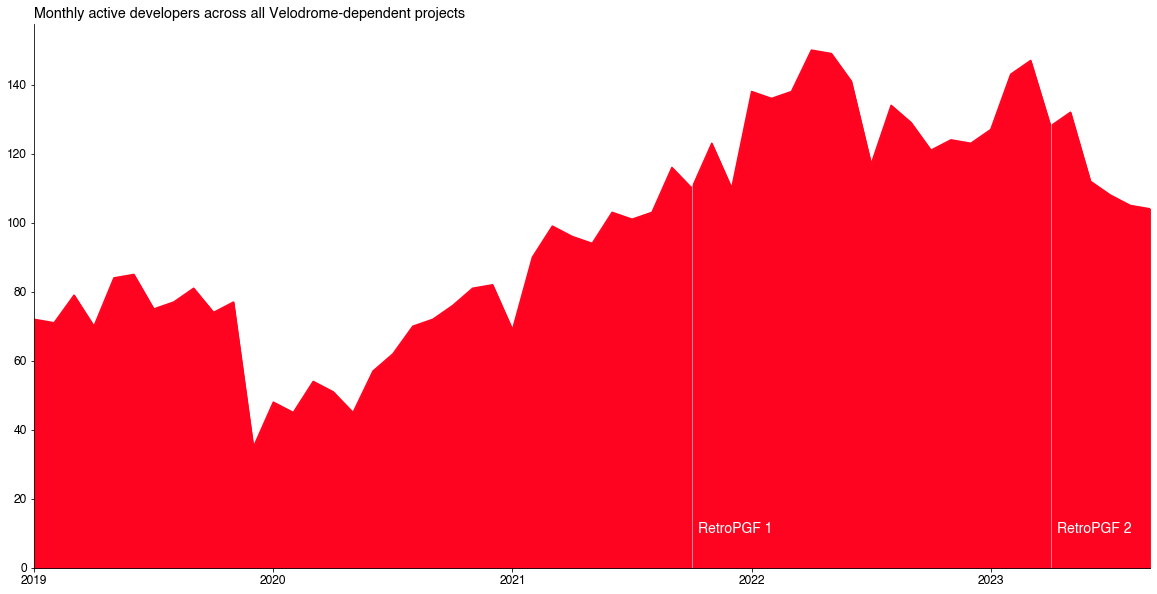

In [33]:
fig, ax = plt.subplots(figsize=(20,10))
df_devs.groupby('month')['sum'].sum().plot(kind='area', ax=ax, color=OP_RED)
annualize_ticks(df_devs, ax)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title('Monthly active developers across all Velodrome-dependent projects', fontweight="bold", loc='left')

ax.vlines(x=33, ymin=0, ymax=600, colors='white', lw=.5)
ax.text(x=33.3, y=10, s='RetroPGF 1', color='white', fontsize=14)
ax.vlines(x=51, ymin=0, ymax=600, colors='white', lw=.5)
ax.text(x=51.3, y=10, s='RetroPGF 2', color='white', fontsize=14)

Text(0.0, 1.0, 'Monthly active developers by Velodrome project\n')

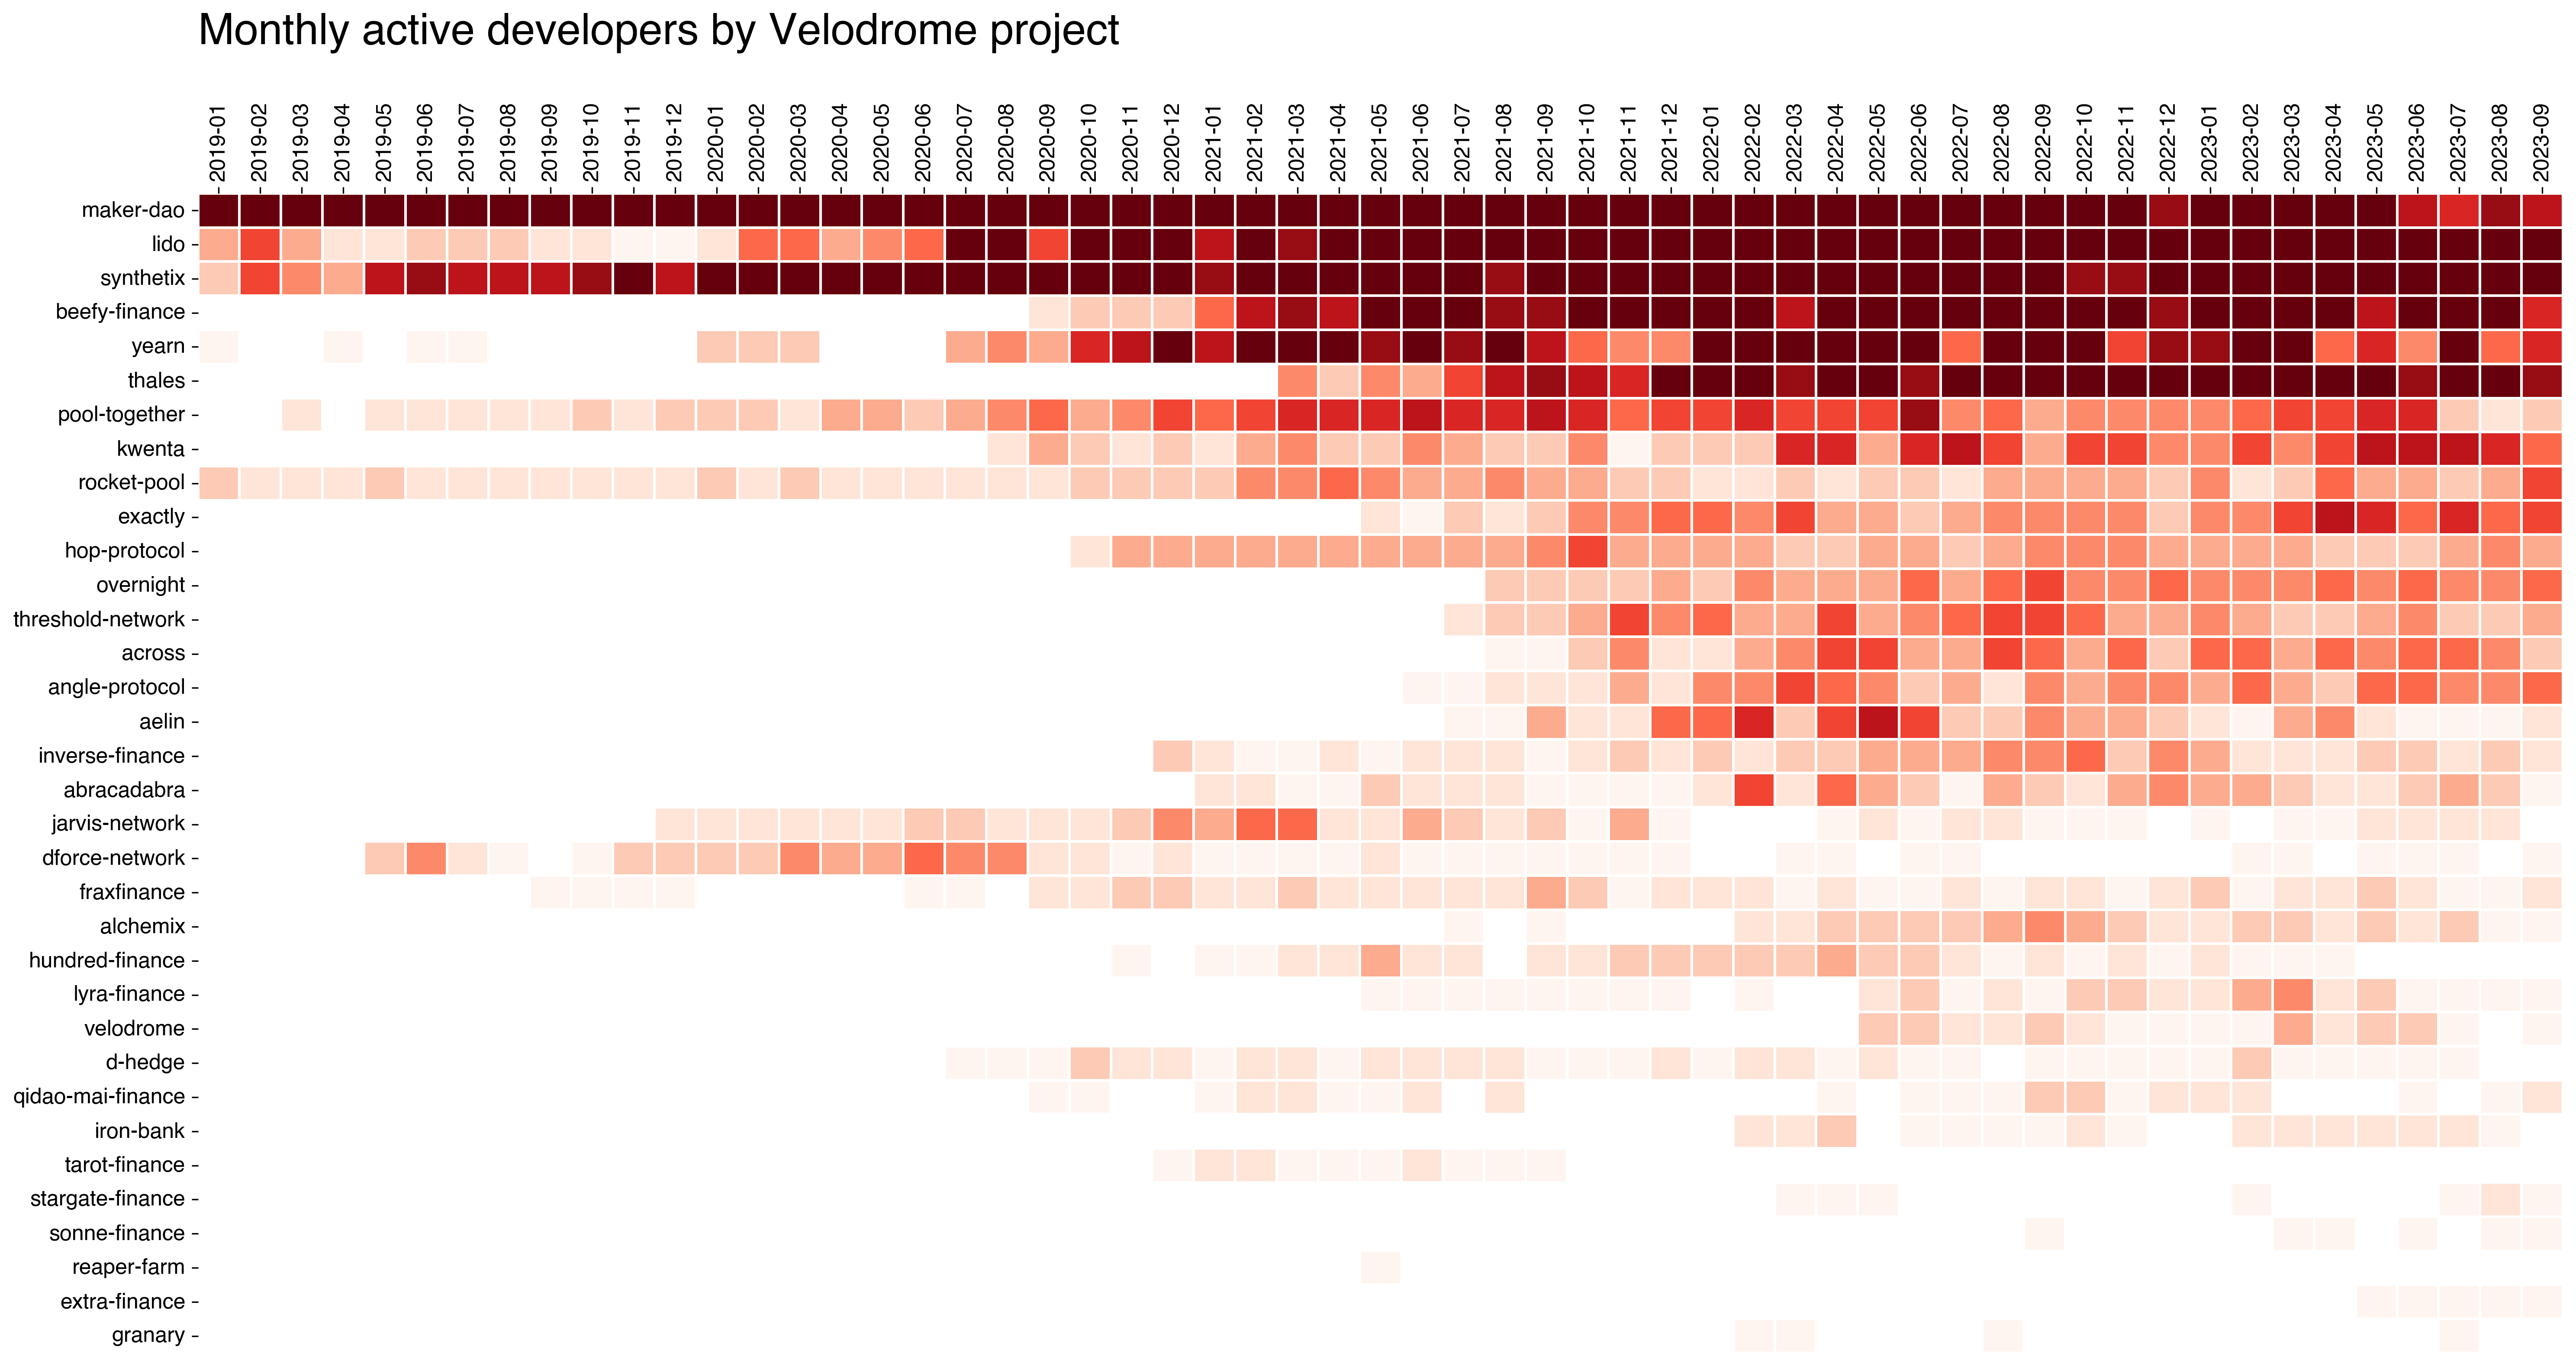

In [53]:
df_devs['project'] = df_devs['slug'].map(slugs_to_names)

fig, ax = contribution_heatmap(
    df_devs,
    index_col='slug',
    column_col='month',
    value_col='sum',
    sort_label_method='mean',
    dpi=300,
    cmap='Reds',
    figsize=(20,10)
)

ax.set_title("Monthly active developers by Velodrome project\n", fontweight="bold", loc='left', fontsize=24)

# Onchain trends

In [54]:
slugs_param = "','".join(slugs)

results = execute_query(f"""
    SELECT 
        p.slug AS slug, 
        a.type AS artifact_type, 
        COUNT(DISTINCT a.id) AS count_artifacts
    FROM project p
    JOIN project_artifacts_artifact paa ON p."id" = paa."projectId"
    JOIN artifact a ON paa."artifactId" = a."id"
    WHERE p.slug IN ('{slugs_param}') AND a.namespace <> 'ETHEREUM'
    GROUP BY p.slug, a.type;
""", col_names=True)

df_artifacts = pd.DataFrame(results[1:], columns=results[0])
df_artifacts.head()

,slug,artifact_type,count_artifacts
0,abracadabra,EOA_ADDRESS,2
1,abracadabra,CONTRACT_ADDRESS,100
2,abracadabra,FACTORY_ADDRESS,11
3,abracadabra,GIT_REPOSITORY,16
4,across,EOA_ADDRESS,1


In [55]:
onchain = df_artifacts[df_artifacts['artifact_type'].isin(['FACTORY_ADDRESS', 'CONTRACT_ADDRESS'])]['slug'].unique()
len(onchain)

33

In [56]:
onchain_slugs_param = "','".join(onchain)

users_query = execute_query(f"""
    WITH Users AS (
        SELECT 
            p."slug" AS "slug",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM') AS "month",
            COUNT(DISTINCT e."fromId") AS "user_nums"
        FROM event e
        JOIN project_artifacts_artifact paa ON e."toId" = paa."artifactId"            
        JOIN project p ON paa."projectId" = p.id         
        WHERE
            e."typeId" = 25 -- TXN EVENTS ONLY
            AND p.slug IN ('{onchain_slugs_param}')
        GROUP BY
            p."slug",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM')
    )
    SELECT 
        slug,
        month,
        SUM("user_nums")
    FROM Users
    WHERE month < '2023-11'
    GROUP BY slug, month;
""", col_names=True)

df_users = pd.DataFrame(users_query[1:], columns=users_query[0])
df_users['sum'] = df_users['sum'].apply(int)
df_users['project'] = df_users['slug'].map(slugs_to_names)
df_users.head()

,slug,month,sum,project
0,abracadabra,2022-07,1,NaN
1,abracadabra,2022-08,2,NaN
2,abracadabra,2022-11,5,NaN
3,abracadabra,2022-12,1,NaN
4,abracadabra,2023-01,7,NaN


Text(0.0, 1.0, 'Monthly onchain users by Velodrome project\n')

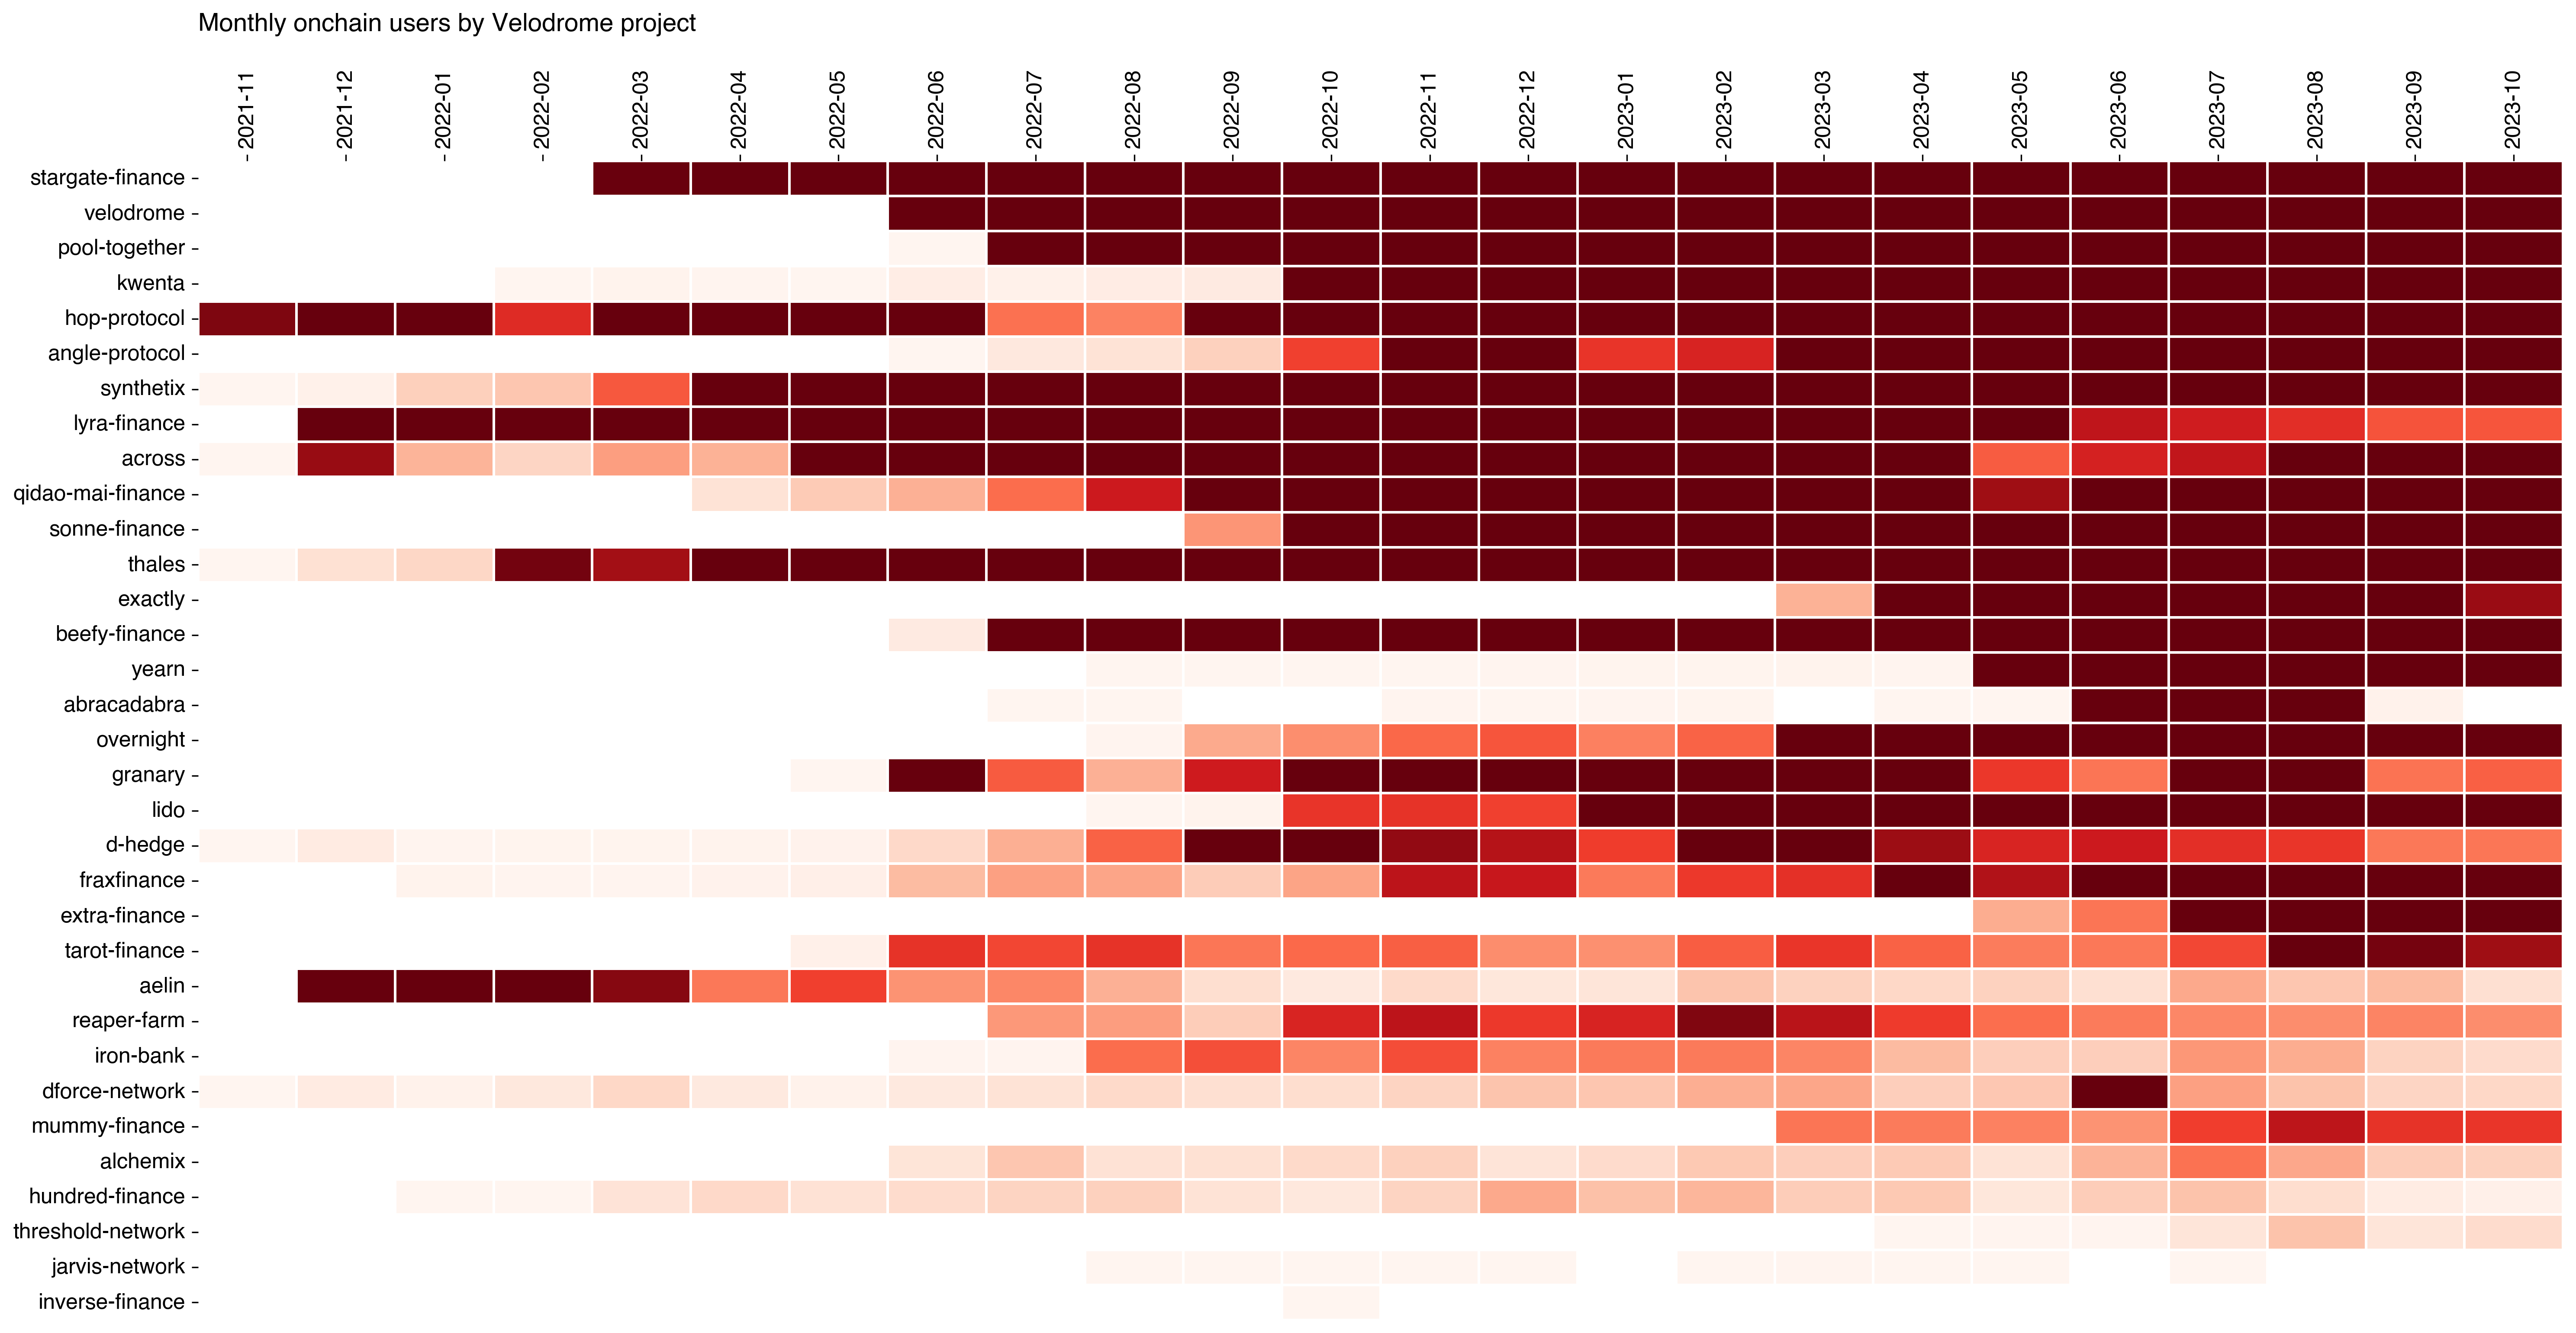

In [64]:
fig, ax = contribution_heatmap(
    df_users,
    index_col='slug',
    column_col='month',
    value_col='sum',
    apply_groupby=False,
    sort_label_method='mean',
    vmax=1000,
    dpi=300,
    cmap='Reds',
    figsize=(20,10)
)

ax.set_title("Monthly onchain users by Velodrome project\n", fontweight="bold", loc='left', fontsize=14)

In [58]:
all_users_query = execute_query(f"""
    SELECT 
        p."slug" AS "slug",
        e."fromId" AS "user",
        TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM') AS "month",
        SUM(e."amount") as "txns"
    FROM event e
    JOIN project_artifacts_artifact paa ON e."toId" = paa."artifactId"            
    JOIN project p ON paa."projectId" = p.id         
    WHERE
        e."typeId" = 25 -- TXN EVENTS ONLY
        AND p.slug IN ('{onchain_slugs_param}')
    GROUP BY
        p."slug",
        e."fromId",
        TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM')
""", col_names=True)
df_all_users = pd.DataFrame(all_users_query[1:], columns=all_users_query[0])

In [59]:
# one app users
users_per_app = df_all_users.groupby('slug')['user'].nunique()

apps_per_user = df_all_users.groupby('user')['slug'].nunique()
multi_app_users = apps_per_user[apps_per_user>=3].index
maus_by_app = df_all_users[df_all_users['user'].isin(multi_app_users)].groupby('slug')['user'].nunique()

txns_per_user = df_all_users.groupby('user')['txns'].sum()
most_active_users = txns_per_user[txns_per_user>=30].index
recent_users = df_all_users[df_all_users['month'] >= '2023-08']['user'].index
hvaus = set(most_active_users).intersection(set(recent_users))
hvaus_by_app = df_all_users[df_all_users['user'].isin(hvaus)].groupby('slug')['user'].nunique()

In [60]:
print(len(apps_per_user))
print(len(multi_app_users))
print(len(hvaus))

1916976
299460
18805


In [61]:
pct = lambda x: round((x / users_per_app).fillna(0) * 100, 0)

project_user_summary = pd.concat([
    users_per_app.rename("# Users"),
    pct(maus_by_app).rename("% Multi-App Users"),    
    pct(hvaus_by_app).rename("% High Value Active Users")    
], axis=1).fillna(0).reset_index()

project_user_summary = project_user_summary[project_user_summary['# Users']>=420]
project_user_summary = project_user_summary[project_user_summary['slug'] != 'polynomial-protocol']

project_user_summary.set_index('slug', drop=True, inplace=True)
project_user_summary.sort_values(by='# Users', inplace=True, ascending=False)
#project_user_summary['# Users'] = project_user_summary['# Users'].apply(lambda s: f"{s:,.0f}")

Text(0, 0.5, 'High value active users (%)')

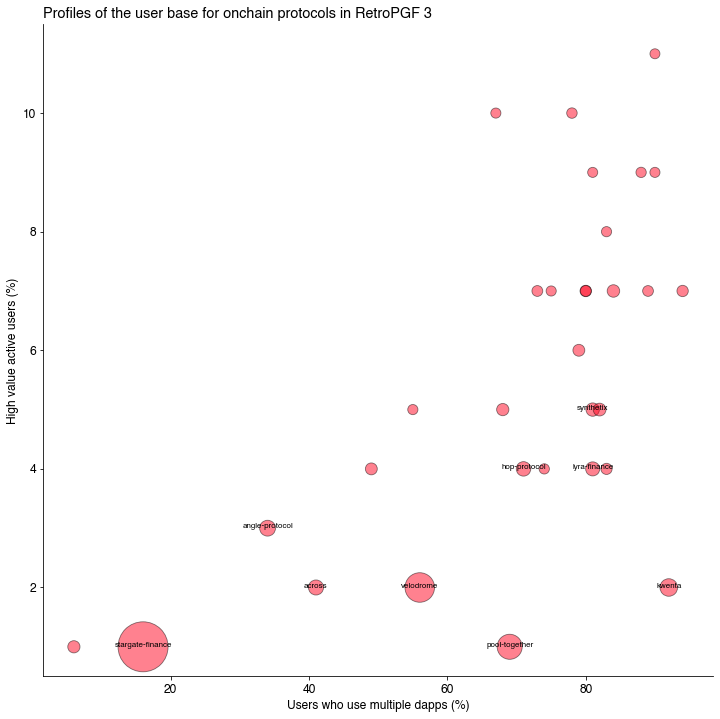

In [62]:
fig, ax = plt.subplots(figsize=(12,12))

sns.scatterplot(
    project_user_summary,
    x='% Multi-App Users',
    y='% High Value Active Users',
    size='# Users',
    color=OP_RED,
    alpha=.5,
    edgecolor='black',
    sizes=(100,2500),
    legend=False
)

for project, row in project_user_summary.iterrows():
    if row['# Users'] < 50000:
        continue
    ax.text(x=row['% Multi-App Users'], y=row['% High Value Active Users'], s=project, fontsize=8, ha='center')
    
ax.set_title('Profiles of the user base for onchain protocols in RetroPGF 3', fontweight="bold", loc='left')
ax.set_xlabel("Users who use multiple dapps (%)", fontweight='bold')
ax.set_ylabel("High value active users (%)", fontweight='bold')

Text(0.0, 1.0, 'The first dapp that "high value active users" interacted with on OP')

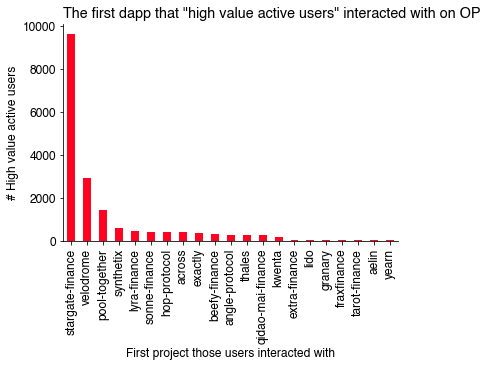

In [63]:
earliest_projects = df_all_users[df_all_users['user'].isin(hvaus)].sort_values(by='month').groupby('user').first().reset_index()
ep_series = earliest_projects['slug'].value_counts()
ep_series = ep_series[ep_series>50]

fig, ax = plt.subplots()
ep_series.plot(kind='bar', color=OP_RED, ax=ax)
ax.set_xlabel("First project those users interacted with", fontweight='bold')
ax.set_ylabel("# High value active users", fontweight='bold')
ax.set_title('The first dapp that "high value active users" interacted with on OP', fontweight="bold", loc='left')

# Direct and indirect impact

In [46]:
import plotly.express as px

In [47]:
fees_query = execute_query(f"""
    SELECT 
        p."slug" AS "slug",
        SUM(e."amount") as "fees"
    FROM event e
    JOIN project_artifacts_artifact paa ON e."toId" = paa."artifactId"            
    JOIN project p ON paa."projectId" = p.id         
    WHERE e."typeId" = 26 -- L2 FEES
    GROUP BY p."slug"
""", col_names=True)
df_fees = pd.DataFrame(fees_query[1:], columns=fees_query[0])

In [48]:
project_names = execute_query("select slug, name from project", col_names=False)
project_names = {x[0]:x[1] for x in project_names}

In [65]:
df_fees['project'] = df_fees['slug'].map(project_names)
df_fees['group'] = df_fees['slug'].apply(lambda x: 'Velodrome' if x in onchain else "Other protocols")
df_fees['fees'] = df_fees['fees'] / 1e18
df_fees

,slug,fees,project,group
0,0x-splits,3.320790e-21,0xSplits,Other protocols
1,1-inch,9.696114e-18,1Inch,Other protocols
2,1w3,6.217032e-24,1W3,Other protocols
3,2-pi-network,2.983372e-21,2Pi Network,Other protocols
4,aave,5.882677e-19,Aave,Other protocols
...,...,...,...,...
216,yokifinance,2.535692e-23,Yoki Finance,Other protocols
217,zerion,5.037158e-19,Zerion,Other protocols
218,zeroex,3.119107e-17,zeroex,Other protocols
219,zonicapp,8.421602e-21,ZonicApp,Other protocols


In [69]:
print(len(df_fees[df_fees['group']=='Other protocols']))
df_fees.groupby('group')['fees'].sum() * 1e18

188


group
Other protocols    860.131289
Velodrome          182.074264
Name: fees, dtype: float64

In [67]:
px.treemap(data_frame=df_fees, path=['group', 'project'], values='fees', title='Sequencer fee contribution by protocol')